Raw rows: 541909
Clean rows: 397924


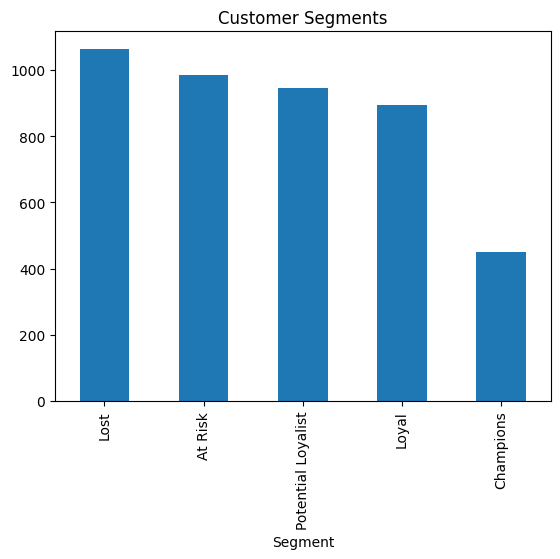

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/content/data.csv", encoding="latin1")

print("Raw rows:", len(df))
df.head()

df.columns

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Remove missing customers
df = df.dropna(subset=["CustomerID"])

print("Clean rows:", len(df))

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["Total"] = df["Quantity"] * df["UnitPrice"]

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "count",
    "Total": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

rfm["R"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)


def segment(score):
    if score >= "444":
        return "Champions"
    elif score >= "344":
        return "Loyal"
    elif score >= "244":
        return "Potential Loyalist"
    elif score >= "144":
        return "At Risk"
    else:
        return "Lost"

rfm["Segment"] = rfm["RFM_Score"].apply(segment)

rfm["Segment"].value_counts().plot(kind="bar", title="Customer Segments")
plt.show()

rfm.reset_index().to_csv("rfm_segments.csv", index=False)
